## 과제 목표

1. PyTorch를 이용한 딥러닝 모델 구축 및 학습 방법 이해
2. Fully connected network와 CNN 모델의 이해
3. 이미지 분류기 구축 및 학습

# 환경 세팅

본 실습에서 사용할 라이브러리를 import 하겠습니다.

In [176]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

딥러닝 모델은 매우 큰 행렬 연산을 빠르게 수행해야 합니다. 때문에 CPU만으로는 연산이 느리거나 불가능한 경우가 많습니다. 따라서 GPU를 주로 사용합니다. 아래 `set_device` 함수는 디바이스를 설정합니다.

> 🪄 Colab에서 GPU를 사용하려면 우측 상단의 '추가 연결 옵션'(RAM, 디스크 statistic 옆 화살표 버튼)에서 [런타임 유형 변경] - [하드웨어 가속기] 에서 GPU로 옵션을 변경해주세요.

In [177]:
def set_device(use_gpu):
    """Set the device to run the code.

    Choose CUDA (GPU) if you want to use & it is available,
    if not, choose CPU.

    Args:
        use_gpu (bool): whether you want to use GPU
    Returns:
        Torch.device: device to use in the code
    """
    if use_gpu and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using Device: {device}")
    return device

# Test the function
device = set_device(use_gpu="True")
print(f"Device: {device}")

Using Device: cuda
Device: cuda


아래는 본 실습에 사용할 설정 값입니다.

In [178]:
class Config:
    def __init__(
        self,
        use_gpu=True,
        lr=1e-2,
        epoch=5,
        log_interval=100,
        dataset_path='./datasets',
        image_size=32,
        num_train_data=49000,
        batch_size=64,
        mlp_hidden_dim=512,
        cnn_in_channel=3,
        cnn_channel1=12,
        cnn_channel2=8,
    ):
        # 모델 학습 관련 설정
        self.use_gpu = use_gpu # GPU 사용 여부
        self.lr = lr # learning rate
        self.epoch = epoch # epoch 수
        self.log_interval = log_interval # 실행 상황을 출력할 빈도

        # 데이터셋 설정
        self.dataset_path = dataset_path # 데이터셋을 다운받을 위치
        self.classes = ( # 클래스 종류
            'plane', 'car', 'bird', 'cat','deer',
            'dog', 'frog', 'horse', 'ship', 'truck',
        )
        self.num_classes = len(self.classes) # 클래스 개수
        self.image_size = image_size # 이미지의 가로/세로 크기

        # 데이터 로더 설정
        self.num_train_data = num_train_data # training set으로 사용할 이미지 개수
        self.batch_size = batch_size # 한 배치 당 이미지 개수. GPU 성능이 낮을 경우 더 낮게 설정. 보통 2의 제곱수.

        # FCN 사용 시 설정
        self.mlp_input_size = self.image_size * self.image_size * 3 # MLP 입력 크기
        self.mlp_hidden_dim = mlp_hidden_dim # MLP hidden layers의 데이터 차원

        # CNN 사용 시 설정
        self.cnn_in_channel = cnn_in_channel # CNN 입력 채널 수
        self.cnn_channel1 = cnn_channel1 # CNN 은닉층1 채널 수
        self.cnn_channel2 = cnn_channel2 # CNN 은닉층2 채널 수

        # 실행 디바이스 설정
        self.device = set_device(self.use_gpu)

        # 데이터셋 다운로드 폴더 생성
        if not os.path.exists(self.dataset_path):
            os.makedirs(self.dataset_path, exist_ok=True)

# Basic Neural Network 구현하기

## 1. 데이터셋 내 데이터를 시각화하는 함수 구현

0~255 사이의 픽셀값을 가지는 이미지 데이터를 모델이 처리할 수 있도록 텐서로 변경하고 [-1, 1] 범위로 픽셀 값을 정규화하는 data transformation을 정의합니다.

In [179]:
def get_transform():
    transform = T.Compose([
        T.ToTensor(), # 텐서화
        T.Normalize(  # 정규화 (각 채널의 mean과 std를 지정)
            mean = (0.5, 0.5, 0.5),
            std  = (0.5, 0.5, 0.5),
        ),
    ])
    return transform

CIFAR10 데이터셋을 다운받아 가져오고, 데이터로더를 선언해 데이터를 가져오는 방식을 지정합니다.

In [180]:
def make_dataloader(dataset_path, batch_size, transform):
    # Dataset split
    cifar10_train = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_val = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_test = torchvision.datasets.CIFAR10(
        dataset_path, train=False, download=True, transform=transform,
    )

    # Dataloader
    loader_train = DataLoader(
        dataset    = cifar10_train,
        batch_size = batch_size,
        shuffle    = True, # 데이터셋 내 데이터를 가져오는 순서를 섞음
        drop_last  = True, # 맨 마지막 배치가 배치 크기에 맞지 않을 경우 버림
    )

    loader_val = DataLoader(
        dataset    = cifar10_val,
        batch_size = batch_size,
        shuffle    = True,
    )

    loader_test = DataLoader(
        dataset    = cifar10_test,
        batch_size = batch_size,
        shuffle    = False,
    )

    return loader_train, loader_val, loader_test

가져온 데이터셋 내 데이터가 어떻게 생겼는지 보기 위하여, 시각화 함수를 만들어보겠습니다.

앞서 이미지를 텐서로 만들고 정규화하는 transformation을 거쳤는데, 시각화를 위해서는 이를 다시 되돌려야합니다. 또한 화면에 띄우는 작업도 필요합니다. 이 과정을 수행하는 함수 `visualize()`를 구현합니다.

In [181]:
############################################################################
# Req 2-1: 데이터셋 내 데이터를 시각화하는 함수 구현                             #
############################################################################
def visualize(img):
    """
    Args:
        img (torch.Tensor): A image to visualize, shape: [C, H, W]
    """
    ################################################################################
    # TODO: 데이터로더가 가져온 데이터셋 내 이미지(`img`)를 입력 받아 transform되었던      #
    # 형태를 다시 되돌리고, 이를 화면에 출력한다.                                        #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) [-1, -1] 범위로 normalize된 데이터를 [0,1] 범위로 unnormalize
    # 2) Tensor형인 이미지를 numpy 배열로 변환
    # 3) [Channel, Hight, Width] 순서의 축을 [Hight, Width, Channel] 순서로 변경
    # 4) matplotlib의 plt.imshow() 함수로 시각화

    """Write your code"""
     # 1) [-1, 1] 범위로 normalize된 데이터를 [0, 1] 범위로 unnormalize
    img = (img + 1) / 2  # Normalize된 범위를 [0, 1]로 되돌림

    # 2) Tensor형인 이미지를 numpy 배열로 변환
    img = img.numpy()

    # 3) [Channel, Height, Width] 순서의 축을 [Height, Width, Channel] 순서로 변경
    img = np.transpose(img, (1, 2, 0))

    # 4) matplotlib의 plt.imshow() 함수로 시각화
    plt.imshow(img)
    plt.axis('off')  # 축을 보이지 않게 설정
    plt.show()

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

아래 코드로 데이터셋 및 데이터로더를 불러오고, `visualize()` 함수를 테스트해볼 수 있습니다.

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


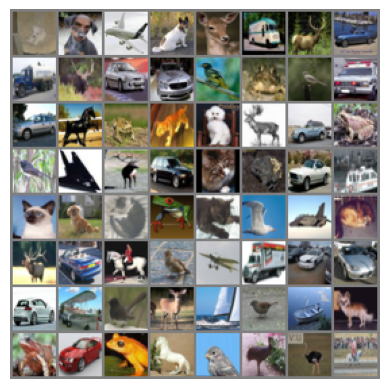

In [182]:
# 실행 디바이스 및 configuration 설정
config = Config()

# 이미지 데이터의 transform 정의하기
transform = get_transform()

# 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 데이터셋의 하나를 뽑아 시각화 함수 사용해보기
images, labels = next(iter(train_loader))
visualize(torchvision.utils.make_grid(images))

## 2. Model 구성하기

아래 구조로 TwoLayerFC 모델과, 해당 모델의 forward 연산을 정의하겠습니다.

- Linear Layer: 이미지를 flatten 할 레이어
- Fully Connected Layer 모듈
    - FC1: input data -> hidden feature
    - ReLU
    - FC2: hidden feature -> output (각 클래스 별 classification 점수)

`nn.Module` 을 상속받은 `TwoLayerFC` 모델의 `__init__` 함수에 모델 레이어를, `forward` 함수에 forward 연산을 정의하면 됩니다.

In [183]:
############################################################################
# Req 2-2: TwoLayerFC 모델 구성하기                                          #
############################################################################

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_dim, num_class):
        """
        Define model layers and initialize model weights

        Args:
            input_size  (int): dimension of input data
            hidden_dim (int): dimension of hidden state
            num_class (int): the number of data classes
        """
        super().__init__()

        ################################################################################
        # TODO: 조건에 맞게 모델의 레이어를 정의함                                          #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) 이미지를 flatten 할 Linear layer 정의
        # 2) 두 개의 FC layer와 그 사이를 잇는 ReLU 활성화함수를 nn.Sequential로 묶어서 하나의 모듈로 정의
        #    - 첫 번째 FC: input data -> hidden feature
        #    - ReLU activation function
        #    - 두 번째 FC: hidden feature -> output (각 클래스 별 classification 점수)

        # 1) 이미지를 flatten할 레이어 정의
        self.flatten = nn.Flatten()
        # 2) 2) 두 개의 FC layer와 그 사이를 잇는 ReLU 활성화함수를 nn.Sequential로 묶어서 하나의 모듈로 정의
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, hidden_dim), # 첫 번째 FC layer: input -> hidden
            nn.ReLU(), # ReLU activation function
            nn.Linear(hidden_dim, num_class) # 두 번째 FC layer: hidden -> output
        )

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        ################################################################################
        # TODO: __init__에서 정의한 레이어 및 모듈을 활용하여 이미지가 각 클래스 별 점수로 나오는 #
        # 연산을 수행함                                                                  #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) 이미지를 flatten하기
        # 2) FC, ReLU, FC를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기

        # 1) 이미지를 flatten하기
        x = self.flatten(x)

        # 2) FC, ReLU, FC를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기
        x = self.linear_block(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return x


모델을 선언하고 레이어의 구성, 모델의 파라미터를 확인하는 방법은 아래와 같습니다.

In [184]:
# 모델을 선언하기
model = TwoLayerFC(
    input_size = config.mlp_input_size,
    hidden_dim = config.mlp_hidden_dim,
    num_class  = config.num_classes,
)

# 모델의 레이어 구성 확인하기
print(model)

# 모델의 파라미터 확인하기
for name, param in model.named_parameters():
    print(f"Layer: {name}\nSize: {param.size()}\nValues : {param[:2]} \n")

TwoLayerFC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_block): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Layer: linear_block.0.weight
Size: torch.Size([512, 3072])
Values : tensor([[ 0.0033,  0.0062,  0.0006,  ...,  0.0037, -0.0118, -0.0157],
        [-0.0119, -0.0107, -0.0028,  ...,  0.0177, -0.0075, -0.0040]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.0.bias
Size: torch.Size([512])
Values : tensor([-0.0161, -0.0119], grad_fn=<SliceBackward0>) 

Layer: linear_block.2.weight
Size: torch.Size([10, 512])
Values : tensor([[-0.0380, -0.0275,  0.0229,  ..., -0.0251, -0.0423,  0.0021],
        [-0.0028, -0.0021, -0.0430,  ..., -0.0097, -0.0177,  0.0245]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.2.bias
Size: torch.Size([10])
Values : tensor([ 0.0207, -0.0141], grad_fn=<SliceBackward0>) 



## 3. 모델 학습과정 구현하기

모델을 학습하는 `train()` 함수를 구현해봅시다. 모델의 가중치가 업데이트되는 학습 과정은 아래와 같이 이루어집니다.

- Optimizer 초기화: 우리가 조정(학습)하려는 모델의 파라미터를 전달합니다.
- 학습 loop 내에서
    - `optimizer.zero_grad()`으로 모델 파라미터의 그래디언트를 리셋합니다.
    - model output 및 loss 계산
    - `loss.backward()`로 backpropagation합니다. PyTorch에서 자동적으로 각 파라미터에 대해 그래디언트를 계산해 저장합니다.
    - `optimizer.step()`으로 위에서 계산한 그래디언트를 이용해 파라미터를 업데이트합니다.

`train()` 함수에서는 학습 loop 내의 내용을 구현합니다.

In [185]:
############################################################################
# Req 2-3: 모델을 학습시키는 train() 함수 구현하기                              #
############################################################################


def train(model, train_loader, optimizer, device, log_interval=50):
    model.train()  # 모델을 train 모드로 설정합니다.

    for step, data in enumerate(train_loader):  # 각 데이터 배치로 각 step을 학습
        # 데이터와 타겟을 분리합니다.
        inputs, targets = data

        # 1) Optimizer `optimizer`의 gradient 값을 초기화
        optimizer.zero_grad()

        # 2) 배치 내 데이터를 `device`로 데이터가 올라갈 디바이스를 지정함
        inputs, targets = inputs.to(device), targets.to(device)

        # 3) Forward pass를 통해 모델의 출력(예측값)을 생성함
        output = model(inputs)

        # 4) cross entropy loss를 계산함
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(output, targets)

        # 5) Loss를 backpropagation하여 gradient를 전달함
        loss.backward()

        # 6) optimizer로 네트워크 가중치를 업데이트함
        optimizer.step()

        # 7) [Optional] 로깅 용으로 loss를 출력함
        if step % log_interval == 0:
            print(f"Step {step} / {len(train_loader)-1} | Loss {loss.item():.4f}")

## 4. 모델 테스트 과정 구현하기

학습한 모델의 정확도(성능)을 측정하는 `test()` 함수를 구현합니다. `train()`과 유사하지만 크게는 아래 두 요소가 다릅니다.

- 모델의 모드 변경: train이 아닌 eval 모드
- Gradient 계산/저장 안 함: `torch.no_grad()`나 `@torch.no_grad()`를 통해 그래디언트 계산을 막습니다. Test에선 불필요하기 때문입니다.
- 성능 측정: accuracy (=맞은 개수/전체 개수)를 계산하여 모델의 성능을 측정합니다.

In [186]:
############################################################################
# Req 2-4: 모델을 평가하는 test() 함수 구현하기                                #
############################################################################

def test(model, dataloader, device, mode="val"):
    """
    모델을 평가하여 정확도와 (선택적으로) 손실 값을 출력합니다.

    Args:
        model (nn.Module): 평가할 모델
        dataloader (DataLoader): 평가에 사용할 데이터로더
        device (torch.device): 모델과 데이터가 위치할 디바이스
        mode (str): 평가 모드 ('val'일 때 손실도 출력)
    """
    cnt_correct = 0  # 전체 셋 중 정답을 맞춘 개수
    tot_num = len(dataloader.dataset)  # 전체 개수
    tot_loss = 0.0  # 손실 총합

    model.eval()  # 모델을 eval 모드로 전환. Batch Normalization을 수행하지 않는 등 필요 없는 작업을 자동으로 끔.

    with torch.no_grad():  # gradient 계산을 하지 않음.
        for step, data in enumerate(dataloader):  # 각 데이터 배치로 평가
            # 데이터와 타겟을 분리
            inputs, targets = data

            # 배치 내 데이터를 `device`로 데이터가 올라갈 디바이스를 지정함
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass를 통해 모델의 출력(예측값)을 생성함
            output = model(inputs)

            # `mode`가 validation(`val`)일 때는 손실 값을 계산함
            if mode == "val":
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(output, targets)
                tot_loss += loss.item()

            # 예측한 클래스를 추출함(top-1). 예측값이 각 클래스의 점수이므로, 값이 최대인 클래스를 찾음
            _, predicted = torch.max(output, 1)

            # 정답을 맞춘 개수를 누적합함
            cnt_correct += (predicted == targets).sum().item()

        # Accuracy를 계산함
        accuracy = cnt_correct / tot_num

        # 결과를 출력함
        print("-" * 30)
        if mode == "val":
            print(f"Validation Loss: {tot_loss / len(dataloader):.4f}")  # 손실 평균 출력
        print(f"Accuracy: {accuracy:.2f} ({cnt_correct} / {tot_num})")
        print("-" * 30)

## 5. 모델 학습 진행하기

앞선 <Req 2-1 ~ 2-4>의 내용을 상기하며 모델의 학습 전체 프로세스를 실행하고, 실제 학습을 진행합니다.

In [187]:
############################################################################
# Req 2-5: 모델 학습 진행하기                                                 #
############################################################################

################################################################################
# TODO: 학습에 사용할 설정값을 불러오고, 데이터셋 및 데이터로더를 불러오며,              #
# 모델 및 optimizer을 선언하고, 학습 iteration을 수행하는 과정을 구현함.              #
# 앞서 각 단계를 구현해두었으므로, 이를 종합하여 실행하는 단계임.                       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 1) 실행 디바이스 및 configuration 설정
# 2) 이미지 데이터의 transform 정의하기
# 3) 데이터로더 불러오기
# 4) 모델을 선언하기
# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
# 6) Optimizer 선언하기: SGD 사용
# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기

# 1) 실행 디바이스 및 configuration 설정
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# 2) 이미지 데이터의 transform 정의하기
transform = T.Compose([
    T.ToTensor(),  # 텐서화
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
])

# 3) 데이터로더 불러오기
batch_size = 64  # 배치 사이즈 설정 (Config의 batch_size와 일치해야 함)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# 4) 모델을 선언하기
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_dim, num_class):
        super(TwoLayerFC, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, hidden_dim),  # 첫 번째 FC layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_dim, num_class)  # 두 번째 FC layer
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_block(x)
        return x

model = TwoLayerFC(input_size=3*32*32, hidden_dim=100, num_class=10)

# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model.to(device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
num_epochs = 5
for epoch in range(num_epochs):
    # 학습
    train(model, train_loader, optimizer, device, log_interval=100)
    # 평가 (validation)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    test(model, test_loader, device, mode="val")
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Files already downloaded and verified
Files already downloaded and verified
Step 0 / 781 | Loss 2.3099
Step 100 / 781 | Loss 1.7116
Step 200 / 781 | Loss 1.8801
Step 300 / 781 | Loss 1.7666
Step 400 / 781 | Loss 1.6920
Step 500 / 781 | Loss 1.4876
Step 600 / 781 | Loss 1.5895
Step 700 / 781 | Loss 1.5386
Epoch 1/5
------------------------------
Validation Loss: 1.5449
Accuracy: 0.45 (4507 / 10000)
------------------------------
Step 0 / 781 | Loss 1.3350
Step 100 / 781 | Loss 1.3629
Step 200 / 781 | Loss 1.6625
Step 300 / 781 | Loss 1.6691
Step 400 / 781 | Loss 1.3701
Step 500 / 781 | Loss 1.3130
Step 600 / 781 | Loss 1.3733
Step 700 / 781 | Loss 1.3132
Epoch 2/5
------------------------------
Validation Loss: 1.4758
Accuracy: 0.48 (4776 / 10000)
------------------------------
Step 0 / 781 | Loss 1.2808
Step 100 / 781 | Loss 1.4542
Step 200 / 781 | Loss 1.4212
Step 300 / 781 | Loss 1.4257
Step 400 / 781 | Loss 1.5870
Step 500 / 781 | Loss 1.4717
Step 600 / 781 | Loss 1.7188
Step 700 / 

# CNN (Convolutional Neural Network) 구현하기

## 6. ThreeLayerConvNet 모델 구성하기

아래 구조로 ThreeLayerConvNet 모델과, 해당 모델의 forward 연산을 정의하겠습니다.

- Convolution layer 1: 5x5 필터, 2 픽셀의 zero padding 사용
- ReLU 활성화함수
- Convolution layer 2: 3x3 필터, 1 픽셀의 zero padding 사용
- ReLU 활성화함수
- Fully connected layer: 각 클래스 별 classification 점수로 매핑할 레이어

<Req 2-2>와 동일한 방법으로 __init__과 forward 함수를 작성합니다.

In [202]:
############################################################################
# Req 2-6: ThreeLayerConvNet 모델 구성하기                                    #
############################################################################

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_class):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # 입력 이미지 크기가 32x32일 때, 두 개의 3x3 convolution layer를 거친 후 feature map의 크기는 8x8
        self.fc = nn.Linear(channel_2 * 32 * 32, num_class) # 크기 조정 잘못하는 오류남 RuntimeError: mat1 and mat2 shapes cannot be multiplied

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        scores = self.fc(x)
        return scores

## 7. 모델 학습 진행하기

앞선 <Req 2-5>와 마찬가지로, ThreeLayerConvNet 모델의 학습 전체 프로세스를 실행하고, 실제 학습을 진행함. 데이터셋 및 데이터로더는 <Req 2-5>와 동일하게 사용합니다.

In [201]:
# 1) 실행 디바이스 및 configuration 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) 이미지 데이터의 transform 정의하기
transform = T.Compose([
    T.ToTensor(),  # 이미지를 텐서로 변환
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지 정규화
])

# 3) 데이터로더 불러오기
batch_size = 64  # 배치 사이즈 설정
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 4) 모델을 선언하기
model = ThreeLayerConvNet(in_channel=3, channel_1=16, channel_2=32, num_class=10)

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_class):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # 입력 이미지 크기가 32x32일 때, 두 개의 3x3 convolution layer를 거친 후 feature map의 크기는 8x8
        self.fc = nn.Linear(channel_2 * 8 * 8, num_class)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        scores = self.fc(x)
        return scores

# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model.to(device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_loader, optimizer, device, log_interval=100)
    test(model, test_loader, device, mode="Validation")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5
Step 0 / 781 | Loss 2.3002
Step 100 / 781 | Loss 1.8510
Step 200 / 781 | Loss 1.6718
Step 300 / 781 | Loss 1.4089
Step 400 / 781 | Loss 1.4358
Step 500 / 781 | Loss 1.0170
Step 600 / 781 | Loss 1.1629
Step 700 / 781 | Loss 1.4652
Epoch 2/5
Step 0 / 781 | Loss 0.9414
Step 100 / 781 | Loss 1.1562
Step 200 / 781 | Loss 1.3047
Step 300 / 781 | Loss 1.0916
Step 400 / 781 | Loss 1.3206
Step 500 / 781 | Loss 0.9763
Step 600 / 781 | Loss 1.0123
Step 700 / 781 | Loss 0.9087
Epoch 3/5
Step 0 / 781 | Loss 0.7315
Step 100 / 781 | Loss 0.8062
Step 200 / 781 | Loss 1.0329
Step 300 / 781 | Loss 1.2268
Step 400 / 781 | Loss 0.8437
Step 500 / 781 | Loss 0.8108
Step 600 / 781 | Loss 1.1634
Step 700 / 781 | Loss 1.0381
Epoch 4/5
Step 0 / 781 | Loss 0.7069
Step 100 / 781 | Loss 0.9165
Step 200 / 781 | Loss 0.7536
Step 300 / 781 | Loss 0.6558
Step 400 / 781 | Loss 0.5690
Step 500 / 781 | Loss 0.8201
Step 600 / 781 | Loss 

# CIFAR-10 Challenge

## 8. 더 높은 정확도의 이미지 분류기 모델 만들기

자유롭게 자신만의 CNN 이미지 분류기 모델을 만들고, CIFAR-10 데이터셋으로 모델을 학습하여 10 에폭 내에서 정확도 70% 이상의 더 높은 성능을 달성합니다.

대표적으로 변경하거나 추가해볼 수 있는 사항은 아래와 같음.
- 모델 구조 (레이어의 구성): Convolution layer의 개수와 입출력 채널 차원 크기, 커널 크기, 패딩 종류 및 크기, pooling layer의 종류와 크기, Fully connected layer의 입력 채널 차원 및 층 개수 등
- 최적화 기법: Adam, AdamW, SGD, RMSprop 등
- 하이퍼파라미터: 배치 크기, 학습률(learning rate) 등
- 정규화 (normalization): 배치 정규화, 레이어 정규화, 그룹 정규화 등
- 활성화함수: ReLU, LeakyReLU, GELU, Sigmoid 등
- 데이터 증강 (augmentation): 뒤집기(flip), 랜덤 자르기(random crop) 등

In [203]:
# 새로운 모델 정의
class DeepConvNet(nn.Module):
    def __init__(self, in_channel, num_class):
        """
        Define model layers and initialize model weights

        Args:
            in_channel (int): number of channels of input data
            num_class (int): the number of data classes
        """
        super(DeepConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # CIFAR-10 이미지 크기 32x32를 4개의 convolution과 max pooling을 거치면 512x2x2가 됩니다.
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, num_class)

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        scores = self.fc2(x)

        return scores

# 데이터 변환 및 데이터 로더 정의
transform = T.Compose([
    T.RandomHorizontalFlip(),   # 데이터 증강: 수평으로 뒤집기
    T.RandomCrop(32, padding=4), # 데이터 증강: 랜덤 크롭
    T.ToTensor(),               # 이미지를 텐서로 변환
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지 정규화
])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 모델, 옵티마이저, 손실 함수 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepConvNet(in_channel=3, num_class=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 학습 함수
def train(model, train_loader, optimizer, criterion, device, log_interval=100):
    model.train()
    for step, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        if step % log_interval == 0:
            print(f"Step {step} / {len(train_loader)-1} | Loss {loss.item():.4f}")

# 평가 함수
def test(model, test_loader, device, mode="val"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# 모델 학습 및 평가
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_loader, optimizer, criterion, device, log_interval=100)
    test(model, test_loader, device, mode="val")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Step 0 / 781 | Loss 2.4063
Step 100 / 781 | Loss 1.9065
Step 200 / 781 | Loss 1.5200
Step 300 / 781 | Loss 1.5240
Step 400 / 781 | Loss 1.7458
Step 500 / 781 | Loss 1.3200
Step 600 / 781 | Loss 1.4709
Step 700 / 781 | Loss 1.5105
Test Accuracy: 54.73%
Epoch 2/10
Step 0 / 781 | Loss 1.2379
Step 100 / 781 | Loss 1.4229
Step 200 / 781 | Loss 1.3432
Step 300 / 781 | Loss 1.4775
Step 400 / 781 | Loss 1.0394
Step 500 / 781 | Loss 1.0917
Step 600 / 781 | Loss 1.2122
Step 700 / 781 | Loss 1.0216
Test Accuracy: 66.27%
Epoch 3/10
Step 0 / 781 | Loss 1.0046
Step 100 / 781 | Loss 1.1204
Step 200 / 781 | Loss 0.9889
Step 300 / 781 | Loss 1.0855
Step 400 / 781 | Loss 0.6686
Step 500 / 781 | Loss 1.1508
Step 600 / 781 | Loss 1.0902
Step 700 / 781 | Loss 0.8365
Test Accuracy: 67.39%
Epoch 4/10
Step 0 / 781 | Loss 0.8794
Step 100 / 781 | Loss 0.5465
Step 200 / 781 | Loss 0.9348
Step 300 / 781 | Loss 0.7682
Step 400 /